In [7]:
import pickle
import os
import pandas as pd
import numpy as np



with open('movie_data.pkl', 'rb') as f:
    data = pickle.load(f)

C:\Users\samul\AppData\Local\Temp\ipykernel_8200\4162024188.py:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [8]:
data = data.rename(columns={"imdbID":"tconst"})

In [9]:
budgets = pd.read_csv("budgets.csv")


In [10]:
# Merge budgets with movie data
data = data.merge(budgets[["tconst", "Production budget"]], on="tconst", how="left")
data = data[~data.duplicated(subset="tconst")]

In [11]:
# Change production budget to int format
data["Production budget"] = data["Production budget"].str.replace(',', '')
data["Production budget"] = data["Production budget"].str.replace('$', '')
data["Production budget"] = data["Production budget"].astype(int)

In [12]:
# compute profit for each titles and drop NA
data["profit"] = data["BoxOffice"].div(data["Production budget"])
data = data.loc[~data["profit"].isna()]

In [13]:
# with open('movie_data_with_budgets.pkl', 'wb') as file:  
#     pickle.dump(data, file)

In [2]:
# Imdb name data
name_basics = pd.read_csv("name.basics.tsv", sep="\t", low_memory=False)

In [3]:
# Imdb title data
title_principals = pd.read_csv("title.principals.tsv", sep="\t", low_memory=False)

In [130]:
# Filter title data to contain only titles that are included in our data
tconst = data["tconst"].tolist()
title_principals = title_principals[title_principals["tconst"].isin(tconst)]

In [22]:
# Filter names
nconst = title_principals["nconst"].tolist()
name_basics = name_basics[name_basics["nconst"].isin(nconst)]

In [27]:
# Join names on titles
title_principals = title_principals.merge(name_basics[["nconst", "primaryName"]], on="nconst", how="left")

In [132]:
# Merge profit
title_principals = title_principals.merge(data[["tconst", "profit"]], on="tconst", how="left")

In [268]:
# Create df for actors that include number of films they have made and the avg profit of the films

# Filter only actors
actor_titles = title_principals.loc[title_principals["category"].isin(["actor", "actress"])].drop_duplicates(subset=["tconst", "nconst"])
# sum of profits
actor_sums = actor_titles.groupby("nconst")["profit"].sum().to_frame()
# number of films made
actor_counts = actor_titles.groupby("nconst")["tconst"].nunique().to_frame()
# create new df
actors_df = actor_counts.join(actor_sums).reset_index()
# Merge name
actors_df = actors_df.merge(name_basics[["nconst", "primaryName"]], on="nconst", how="left")
# Merge actor/actress
actors_df = actors_df.merge(title_principals.loc[title_principals["category"].isin(["actor", "actress"]), ["nconst", "category"]].drop_duplicates(subset="nconst"),\
                on="nconst", how="left")
# divide sum of profits with number of films
actors_df["profit"] = actors_df["profit"].div(actors_df["tconst"])
actors_df = actors_df.rename(columns={"tconst":"nof_films", "profit":"avg_profit"})

# Add log10 of average profit also
actors_df["log_avg_profit"] = actors_df["avg_profit"].round(2).transform(lambda x: np.log10(x) if x > 0 else 0).round(2)

In [249]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler = StandardScaler()

In [269]:
# Standardize number of films and average profit
actors_df[["nof_films_T", "avg_profit_T", "log_avg_profit_T"]] = scaler.fit_transform(actors_df[["nof_films", "avg_profit", "log_avg_profit"]])

In [271]:
# Function to work out optimal number of K for K-mean clustering
import matplotlib.pyplot as plt

def optimise_k_mean(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    # Generate plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, "o-")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

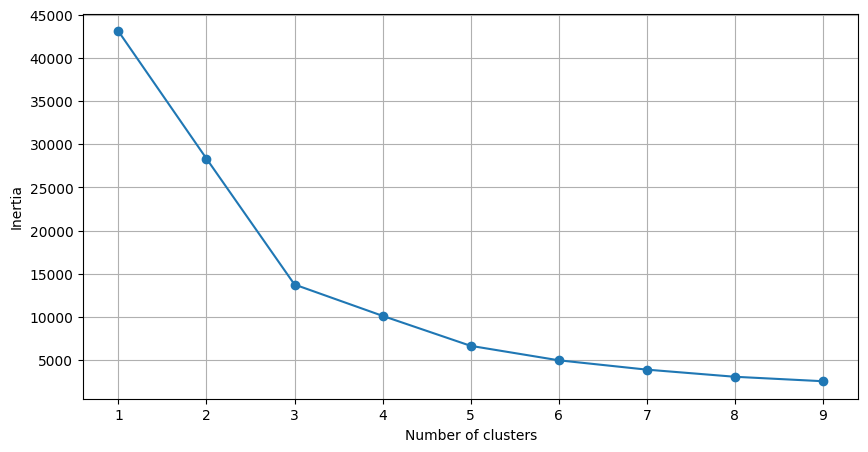

In [274]:
optimise_k_mean(actors_df[["nof_films_T", "avg_profit_T"]], 10)

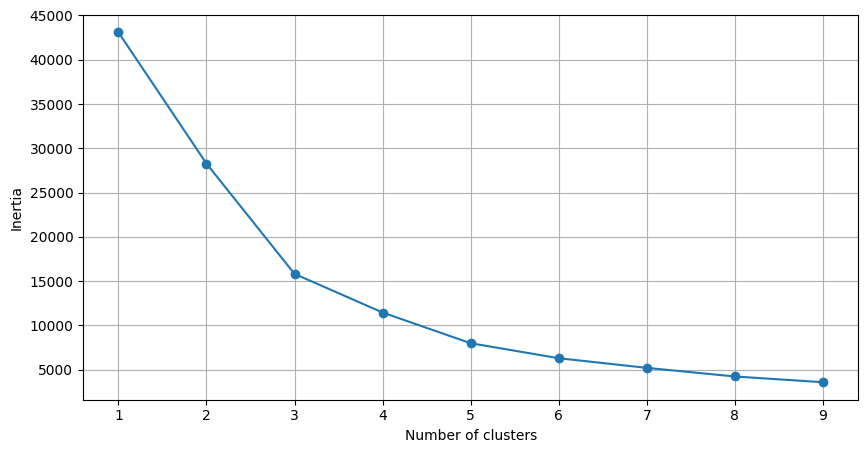

In [278]:
optimise_k_mean(actors_df[["nof_films_T", "log_avg_profit_T"]], 10)

In [291]:
# Apply K Means clustering
kmeans = KMeans(n_clusters=8)
kmeans.fit(actors_df[["nof_films_T", "avg_profit_T"]])
actors_df["kmeans"] = kmeans.labels_

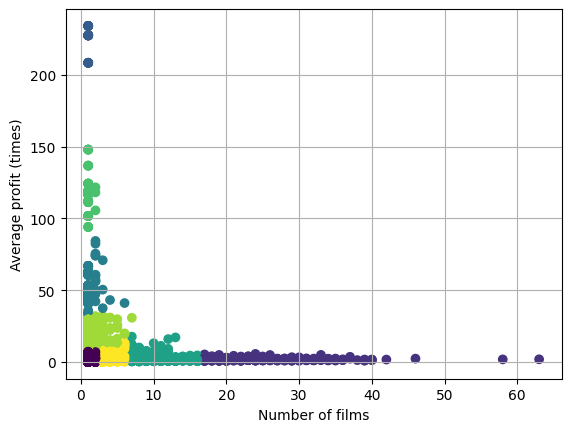

In [316]:
plt.scatter(x=actors_df["nof_films"], y=actors_df["avg_profit"], c=actors_df["kmeans"])
plt.xlabel("Number of films")
plt.ylabel("Average profit (times)")
plt.grid(True)
plt.show()

In [289]:
# Apply K Means clustering for log avg profit

kmeans = KMeans(n_clusters=10)
kmeans.fit(actors_df[["nof_films_T", "log_avg_profit_T"]])
actors_df["kmeans_log"] = kmeans.labels_

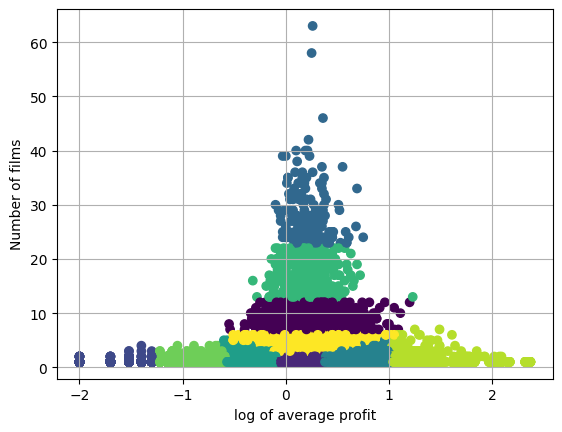

In [317]:
plt.scatter(x=actors_df["log_avg_profit"], y=actors_df["nof_films"], c=actors_df["kmeans_log"])
plt.xlabel("log of average profit")
plt.ylabel("Number of films")
plt.grid(True)
plt.show()

Repeat for directors

In [311]:
# Repeat for directors

# Filter only actors
director_titles = title_principals.loc[title_principals["category"] == "director"].drop_duplicates(subset=["tconst", "nconst"])
# sum of profits
director_sums = director_titles.groupby("nconst")["profit"].sum().to_frame()
# number of films made
director_counts = director_titles.groupby("nconst")["tconst"].nunique().to_frame()
# create new df
director_df = director_counts.join(director_sums).reset_index()
# Merge name
director_df = director_df.merge(name_basics[["nconst", "primaryName"]], on="nconst", how="left")
# Merge directors
director_df = director_df.merge(title_principals.loc[title_principals["category"] == "director", ["nconst", "category"]].drop_duplicates(subset="nconst"),\
                on="nconst", how="left")
# divide sum of profits with number of films
director_df["profit"] = director_df["profit"].div(director_df["tconst"])
director_df = director_df.rename(columns={"tconst":"nof_films", "profit":"avg_profit"})

# Add log10 of average profit also
director_df["log_avg_profit"] = director_df["avg_profit"].round(2).transform(lambda x: np.log10(x) if x > 0 else 0).round(2)

In [313]:
# Apply K Means clustering

director_df[["nof_films_T", "avg_profit_T", "log_avg_profit_T"]] = scaler.fit_transform(director_df[["nof_films", "avg_profit", "log_avg_profit"]])
kmeans = KMeans(n_clusters=8)
kmeans.fit(director_df[["nof_films_T", "avg_profit_T"]])
director_df["kmeans"] = kmeans.labels_

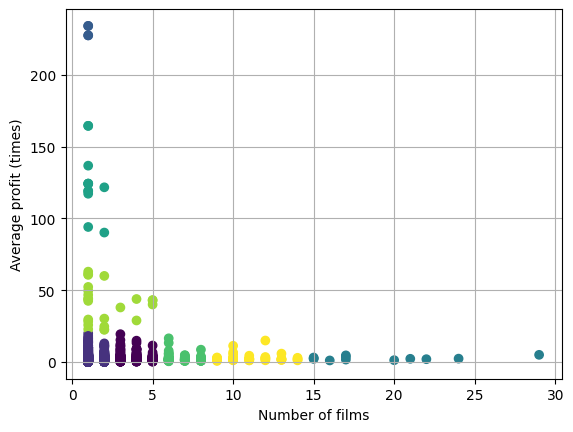

In [315]:
plt.scatter(x=director_df["nof_films"], y=director_df["avg_profit"], c=director_df["kmeans"])
plt.xlabel("Number of films")
plt.ylabel("Average profit (times)")
plt.grid(True)
plt.show()

And for writers

In [319]:
# Repeat for writers

# Filter only actors
writer_titles = title_principals.loc[title_principals["category"] == "writer"].drop_duplicates(subset=["tconst", "nconst"])
# sum of profits
writer_sums = writer_titles.groupby("nconst")["profit"].sum().to_frame()
# number of films made
writer_counts = writer_titles.groupby("nconst")["tconst"].nunique().to_frame()
# create new df
writer_df = writer_counts.join(writer_sums).reset_index()
# Merge name
writer_df = writer_df.merge(name_basics[["nconst", "primaryName"]], on="nconst", how="left")
# Merge writers
writer_df = writer_df.merge(title_principals.loc[title_principals["category"] == "writer", ["nconst", "category"]].drop_duplicates(subset="nconst"),\
                on="nconst", how="left")
# divide sum of profits with number of films
writer_df["profit"] = writer_df["profit"].div(writer_df["tconst"])
writer_df = writer_df.rename(columns={"tconst":"nof_films", "profit":"avg_profit"})

# Add log10 of average profit also
writer_df["log_avg_profit"] = writer_df["avg_profit"].round(2).transform(lambda x: np.log10(x) if x > 0 else 0).round(2)

In [320]:
# Apply K Means clustering

writer_df[["nof_films_T", "avg_profit_T", "log_avg_profit_T"]] = scaler.fit_transform(writer_df[["nof_films", "avg_profit", "log_avg_profit"]])
kmeans = KMeans(n_clusters=8)
kmeans.fit(writer_df[["nof_films_T", "avg_profit_T"]])
writer_df["kmeans"] = kmeans.labels_

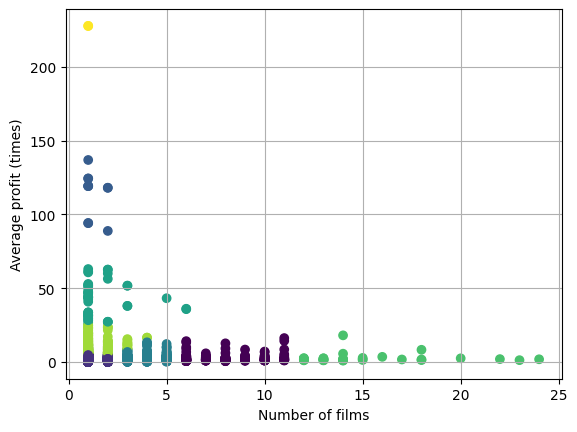

In [321]:
plt.scatter(x=writer_df["nof_films"], y=writer_df["avg_profit"], c=writer_df["kmeans"])
plt.xlabel("Number of films")
plt.ylabel("Average profit (times)")
plt.grid(True)
plt.show()

In [322]:
actors_df.to_csv("actors_cluster.csv")
director_df.to_csv("directors_cluster.csv")
writer_df.to_csv("writers_cluster.csv")